In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

Format of the file: age_gender_ethnicity_datetime 

In [2]:
path = "/kaggle/input/utkface-new/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
26_0_2_20170104023102422.jpg.chip.jpg


In [5]:
import cv2
images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]) )

In [7]:
len(images)

23708

In [16]:
len(ages)

23708

In [13]:
images[0]

array([[[ 8],
        [ 4],
        [ 6],
        ...,
        [17],
        [18],
        [44]],

       [[14],
        [ 3],
        [12],
        ...,
        [22],
        [10],
        [35]],

       [[25],
        [ 4],
        [12],
        ...,
        [14],
        [15],
        [20]],

       ...,

       [[81],
        [84],
        [71],
        ...,
        [ 5],
        [ 5],
        [10]],

       [[47],
        [26],
        [17],
        ...,
        [ 1],
        [ 4],
        [ 5]],

       [[38],
        [10],
        [ 1],
        ...,
        [ 8],
        [ 1],
        [ 6]]], dtype=uint8)

In [42]:
img1=images[:20000]
age1=ages[:20000]
gender1=genders[:20000]

In [45]:
len(img1)

20000

In [43]:
len(age1)

20000

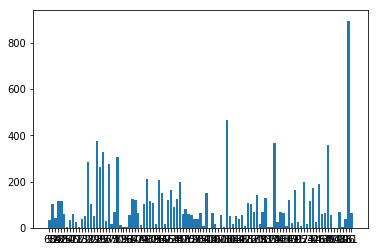

Max value: 99


In [28]:
import matplotlib.pyplot as plt
x_ages = list(set(age1))
y_ages = [age1.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(age1))

Gender: 0 Age: 54


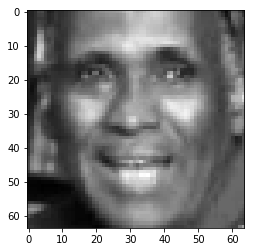

In [46]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
idx = 500
sample = img1[idx]
print("Gender:",gender1[idx],"Age:",age1[idx])
display(sample)

In [48]:
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

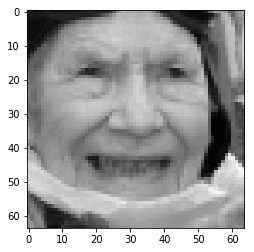

In [49]:
# pre processing
target = np.zeros((20000,2),dtype='float32')
features = np.zeros((20000,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(20000):
    target[i,0] = age_group(int(age1[i])) / 4
    target[i,1] = int(gender1[i])
    features[i] = img1[i]
features = features / 255
display(features[550])

In [50]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 16000
Samples in Testing: 4000


In [51]:
print("Shape of image:",sample.shape)

Shape of image: (64, 64, 1)


In [53]:
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K

In [54]:
inputs = Input(shape=(64,64,1))
conv1 = Conv2D(32, kernel_size=(3, 3),activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3),activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3),activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
flat = Flatten()(x)

dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

In [55]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])

In [56]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 62, 62, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 60, 60, 64)   18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 30, 30, 64)   0           conv2d_5[0][0]                   
____________________________________________________________________________________________

In [57]:
h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 10, batch_size=128,shuffle = True)

Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 169s 11ms/step - loss: 0.8031 - dense_14_loss: 0.1096 - dense_20_loss: 0.6935 - dense_14_accuracy: 0.0120 - dense_20_accuracy: 0.5197 - val_loss: 0.7272 - val_dense_14_loss: 0.0347 - val_dense_20_loss: 0.6922 - val_dense_14_accuracy: 0.0270 - val_dense_20_accuracy: 0.5165
Epoch 2/10
16000/16000 [==============================] - 166s 10ms/step - loss: 0.7272 - dense_14_loss: 0.0529 - dense_20_loss: 0.6743 - dense_14_accuracy: 0.0199 - dense_20_accuracy: 0.5948 - val_loss: 0.6293 - val_dense_14_loss: 0.0281 - val_dense_20_loss: 0.6027 - val_dense_14_accuracy: 0.0282 - val_dense_20_accuracy: 0.7738
Epoch 3/10
16000/16000 [==============================] - 167s 10ms/step - loss: 0.6253 - dense_14_loss: 0.0447 - dense_20_loss: 0.5806 - dense_14_accuracy: 0.0212 - dense_20_accuracy: 0.7338 - val_loss: 0.4617 - val_dense_14_loss: 0.0243 - val_dense_20_loss: 0.4400 - val_dense_14_accurac

In [62]:
model.save('data.h5')

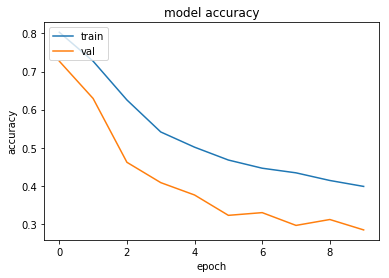

In [60]:
history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show() 

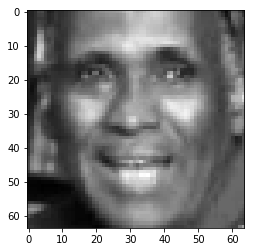

Actual Gender: Male Age: 54
Values: [array([[0.67439973]], dtype=float32), array([[0.20963068]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


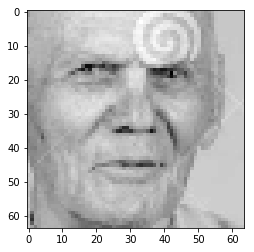

Actual Gender: Male Age: 82
Values: [array([[0.81379753]], dtype=float32), array([[0.04780082]], dtype=float32)] 
Predicted Gender: Male Predicted Age: 31-80


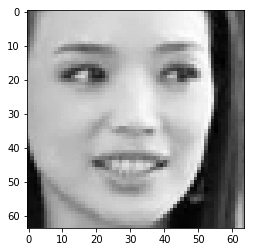

Actual Gender: Female Age: 24
Values: [array([[0.43454865]], dtype=float32), array([[0.99959964]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


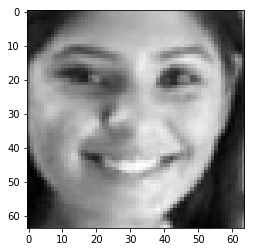

Actual Gender: Female Age: 21
Values: [array([[0.41568917]], dtype=float32), array([[0.9954053]], dtype=float32)] 
Predicted Gender: Female Predicted Age: 19-30


KeyboardInterrupt: 

In [61]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
    
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"
    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )    
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)
    
    
indexes = [500,59,80,2,4546,7,9,256,45]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)